In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import PIL
import pickle

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.3.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# TensorFlow 2.1, Keras - workaround:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [4]:
with open("monet_image_file_names.pickle", "rb") as f:
    monet_image_file_names = pickle.load(f)
with open("monet_images.pickle", "rb") as f:
    monet_images = pickle.load(f)

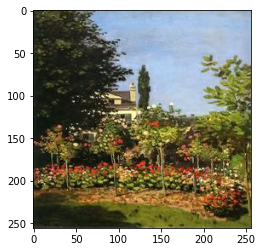

In [5]:
plt.imshow(monet_images[0])

## Generator

In [354]:
GZ1_L = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=[3,3], padding="same")
GB1_L = tf.keras.layers.BatchNormalization(axis=3)
GA1_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU1_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ2_L = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[3,3], padding="same")
GB2_L = tf.keras.layers.BatchNormalization(axis=3)
GA2_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU2_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ3_L = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=[3,3], padding="same")
GB3_L = tf.keras.layers.BatchNormalization(axis=3)
GA3_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU3_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ4_L = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=[3,3], padding="same")
GB4_L = tf.keras.layers.BatchNormalization(axis=3)
GA4_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU4_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GZ5_L = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=[3,3], padding="same")
GB5_L = tf.keras.layers.BatchNormalization(axis=3)
GA5_L = tf.keras.layers.LeakyReLU(alpha=0.1)
GU5_L = tf.keras.layers.UpSampling2D(size=(2, 2))

GY_L = tf.keras.layers.LayerNormalization(axis=3)

def buildup_generator(GX):
    GZ1 = GZ1_L(GX)
    GB1 = GB1_L(GZ1)
    GA1 = GA1_L(GB1)
    GU1 = GU1_L(GA1)

    GZ2 = GZ2_L(GU1)
    GB2 = GB2_L(GZ2)
    GA2 = GA2_L(GB2)
    GU2 = GU2_L(GA2)

    GZ3 = GZ3_L(GU2)
    GB3 = GB3_L(GZ3)
    GA3 = GA3_L(GB3)
    GU3 = GU3_L(GA3)

    GZ4 = GZ4_L(GU3)
    GB4 = GB4_L(GZ4)
    GA4 = GA4_L(GB4)
    GU4 = GU4_L(GA4)

    GZ5 = GZ5_L(GU4)
    GB5 = GB5_L(GZ5)
    GA5 = GA5_L(GB5)
    GU5 = GU5_L(GA5)

    GY = GY_L(GU5)
    return GY

In [355]:
GX = tf.keras.layers.Input(shape=[8, 8, 1], dtype=tf.float32)
GY = buildup_generator(GX)

generator = tf.keras.models.Model(inputs=GX, outputs=GY)
generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
generator.summary()

Model: "functional_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d_transpose_110 (Conv2D (None, 8, 8, 8)           80        
_________________________________________________________________
batch_normalization_284 (Bat (None, 8, 8, 8)           32        
_________________________________________________________________
leaky_re_lu_282 (LeakyReLU)  (None, 8, 8, 8)           0         
_________________________________________________________________
up_sampling2d_228 (UpSamplin (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose_111 (Conv2D (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_285 (Bat (None, 16, 16, 16)     

In [82]:
generator.save('generator.h5')

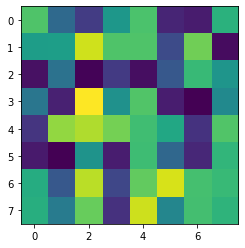

In [358]:
noiseimg = np.random.rand(1, 8, 8, 1)
plt.imshow(np.reshape(noiseimg, (8, 8, 1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


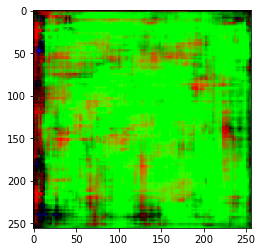

In [359]:
plt.imshow(generator.predict(noiseimg)[0])

## Discriminator

In [331]:
DZ1_L = tf.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], padding="same")
DB1_L = tf.keras.layers.BatchNormalization(axis=3)
DA1_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU1_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ2_L = tf.keras.layers.Conv2D(filters=64, kernel_size=[5, 5], padding="same")
DB2_L = tf.keras.layers.BatchNormalization(axis=3)
DA2_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU2_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ3_L = tf.keras.layers.Conv2D(filters=64, kernel_size=[5, 5], padding="same")
DB3_L = tf.keras.layers.BatchNormalization(axis=3)
DA3_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU3_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ4_L = tf.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], padding="same")
DB4_L = tf.keras.layers.BatchNormalization(axis=3)
DA4_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU4_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DZ5_L = tf.keras.layers.Conv2D(filters=8, kernel_size=[5, 5], padding="same")
DB5_L = tf.keras.layers.BatchNormalization(axis=3)
DA5_L = tf.keras.layers.LeakyReLU(alpha=0.1)
DU5_L = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=[2,2], padding="same")

DF6_L = tf.keras.layers.Flatten()
DZ6_L = tf.keras.layers.Dense(units=16, use_bias=False)
DB6_L = tf.keras.layers.BatchNormalization()
DA6_L = tf.keras.layers.LeakyReLU(alpha=0.1)

DZ7_L = tf.keras.layers.Dense(units=1, use_bias=True)

DY_L = tf.keras.layers.Activation('sigmoid')

def buildup_dicriminator(DX):
    DZ1 = DZ1_L(DX)
    DB1 = DB1_L(DZ1)
    DA1 = DA1_L(DB1)
    DU1 = DU1_L(DA1)

    DZ2 = DZ2_L(DU1)
    DB2 = DB2_L(DZ2)
    DA2 = DA2_L(DB2)
    DU2 = DU2_L(DA2)

    DZ3 = DZ3_L(DU2)
    DB3 = DB3_L(DZ3)
    DA3 = DA3_L(DB3)
    DU3 = DU3_L(DA3)

    DZ4 = DZ4_L(DU3)
    DB4 = DB4_L(DZ4)
    DA4 = DA4_L(DB4)
    DU4 = DU4_L(DA4)

    DZ5 = DZ5_L(DU4)
    DB5 = DB5_L(DZ5)
    DA5 = DA5_L(DB5)
    DU5 = DU5_L(DA5)

    DF6 = DF6_L(DU5)
    DZ6 = DZ6_L(DF6)
    DB6 = DB6_L(DZ6)
    DA6 = DA6_L(DB6)

    DZ7 = DZ7_L(DA6)

    DY = DY_L(DZ7)
    return DY

def set_discriminator(trainable):
    DZ1_L.trainable = trainable
    DB1_L.trainable = trainable
    DZ2_L.trainable = trainable
    DB2_L.trainable = trainable
    DZ3_L.trainable = trainable
    DB3_L.trainable = trainable
    DZ4_L.trainable = trainable
    DB4_L.trainable = trainable
    DZ5_L.trainable = trainable
    DB5_L.trainable = trainable
    DZ6_L.trainable = trainable
    DB6_L.trainable = trainable
    DZ7_L.trainable = trainable    

In [332]:
DX = tf.keras.layers.Input(shape=[256, 256, 3], dtype=tf.float32)
DY = buildup_dicriminator(DX)

discriminator = tf.keras.models.Model(inputs=DX, outputs=DY)
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
discriminator.summary()

Model: "functional_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 256, 256, 32)      2432      
_________________________________________________________________
batch_normalization_278 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_276 (LeakyReLU)  (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 128, 128, 64)      51264     
_________________________________________________________________
batch_normalization_279 (Bat (None, 128, 128, 64)    

In [363]:
discriminator.predict(generator.predict(np.random.rand(batch_semisize, 8, 8, 1)))

array([[1.1448769e-20],
       [6.2791332e-20],
       [3.4261036e-20],
       [1.9849882e-20],
       [8.2810453e-20],
       [1.9581326e-19],
       [1.6924316e-20],
       [9.9358693e-20],
       [1.0170168e-20],
       [1.8123103e-19]], dtype=float32)

In [364]:
discriminator.predict(monet_images[np.random.randint(monet_images.shape[0], size=[10])])
#discriminator.predict(monet_X)

array([[0.99995375],
       [0.9999627 ],
       [0.9999571 ],
       [0.999961  ],
       [0.9999567 ],
       [0.9999622 ],
       [0.9999665 ],
       [0.9999665 ],
       [0.9999571 ],
       [0.99996066]], dtype=float32)

## Learning data for discriminator

In [336]:
batch_semisize = 10

In [337]:
monet_X = monet_images[np.random.randint(monet_images.shape[0], size=[batch_semisize]), :, :, :]
monet_Y = np.array([1] * batch_semisize)

In [338]:
generated_X = generator.predict(np.random.rand(batch_semisize, 8, 8, 1))
generated_Y = np.array([0] * batch_semisize)

In [339]:
perm = np.random.permutation(2 * batch_semisize)
batch_X = np.concatenate((monet_X, generated_X))[perm]
batch_Y = np.concatenate((monet_Y, generated_Y))[perm]

## Train Discriminator

In [343]:
set_discriminator(True)  # trainable
discriminator.fit(tf.convert_to_tensor(batch_X, dtype=tf.float32), tf.convert_to_tensor(batch_Y, dtype=tf.float32), epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0451 - accuracy: 1.0000
Epoch 2/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0422 - accuracy: 1.0000
Epoch 3/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.0395 - accuracy: 1.0000
Epoch 4/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.0369 - accuracy: 1.0000
Epoch 5/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0345 - accuracy: 1.0000
Epoch 6/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0322 - accuracy: 1.0000
Epoch 7/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0300 - accuracy: 1.0000
Epoch 8/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0280 - accuracy: 1.0000
Epoch 9/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0261 - accuracy: 1.0000
Epoch 10/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0244 - accuracy: 1.0000
Epoch 11/

1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 84/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 85/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 86/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 87/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 88/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 89/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 90/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 91/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 92/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 93/1000


1/1 [==============================] - 0s 29ms/step - loss: 6.7657e-04 - accuracy: 1.0000
Epoch 163/1000
1/1 [==============================] - 0s 26ms/step - loss: 6.7026e-04 - accuracy: 1.0000
Epoch 164/1000
1/1 [==============================] - 0s 25ms/step - loss: 6.6403e-04 - accuracy: 1.0000
Epoch 165/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.5790e-04 - accuracy: 1.0000
Epoch 166/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.5185e-04 - accuracy: 1.0000
Epoch 167/1000
1/1 [==============================] - 0s 28ms/step - loss: 6.4589e-04 - accuracy: 1.0000
Epoch 168/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.4001e-04 - accuracy: 1.0000
Epoch 169/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.3422e-04 - accuracy: 1.0000
Epoch 170/1000
1/1 [==============================] - 0s 28ms/step - loss: 6.2851e-04 - accuracy: 1.0000
Epoch 171/1000
1/1 [==============================] - 0s 26ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 3.6534e-04 - accuracy: 1.0000
Epoch 241/1000
1/1 [==============================] - 0s 28ms/step - loss: 3.6290e-04 - accuracy: 1.0000
Epoch 242/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.6049e-04 - accuracy: 1.0000
Epoch 243/1000
1/1 [==============================] - 0s 26ms/step - loss: 3.5810e-04 - accuracy: 1.0000
Epoch 244/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.5574e-04 - accuracy: 1.0000
Epoch 245/1000
1/1 [==============================] - 0s 25ms/step - loss: 3.5340e-04 - accuracy: 1.0000
Epoch 246/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.5108e-04 - accuracy: 1.0000
Epoch 247/1000
1/1 [==============================] - 0s 26ms/step - loss: 3.4879e-04 - accuracy: 1.0000
Epoch 248/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.4652e-04 - accuracy: 1.0000
Epoch 249/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 28ms/step - loss: 2.3050e-04 - accuracy: 1.0000
Epoch 319/1000
1/1 [==============================] - 0s 30ms/step - loss: 2.2930e-04 - accuracy: 1.0000
Epoch 320/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.2811e-04 - accuracy: 1.0000
Epoch 321/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2693e-04 - accuracy: 1.0000
Epoch 322/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2575e-04 - accuracy: 1.0000
Epoch 323/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.2459e-04 - accuracy: 1.0000
Epoch 324/1000
1/1 [==============================] - 0s 29ms/step - loss: 2.2344e-04 - accuracy: 1.0000
Epoch 325/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2229e-04 - accuracy: 1.0000
Epoch 326/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2116e-04 - accuracy: 1.0000
Epoch 327/1000
1/1 [==============================] - 0s 26ms/step - l

1/1 [==============================] - 0s 28ms/step - loss: 1.5940e-04 - accuracy: 1.0000
Epoch 397/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.5871e-04 - accuracy: 1.0000
Epoch 398/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.5804e-04 - accuracy: 1.0000
Epoch 399/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.5736e-04 - accuracy: 1.0000
Epoch 400/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.5669e-04 - accuracy: 1.0000
Epoch 401/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.5603e-04 - accuracy: 1.0000
Epoch 402/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.5537e-04 - accuracy: 1.0000
Epoch 403/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.5471e-04 - accuracy: 1.0000
Epoch 404/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.5406e-04 - accuracy: 1.0000
Epoch 405/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 24ms/step - loss: 1.1711e-04 - accuracy: 1.0000
Epoch 475/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1668e-04 - accuracy: 1.0000
Epoch 476/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1626e-04 - accuracy: 1.0000
Epoch 477/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.1584e-04 - accuracy: 1.0000
Epoch 478/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1542e-04 - accuracy: 1.0000
Epoch 479/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1500e-04 - accuracy: 1.0000
Epoch 480/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.1459e-04 - accuracy: 1.0000
Epoch 481/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1417e-04 - accuracy: 1.0000
Epoch 482/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1376e-04 - accuracy: 1.0000
Epoch 483/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 30ms/step - loss: 8.9811e-05 - accuracy: 1.0000
Epoch 553/1000
1/1 [==============================] - 0s 27ms/step - loss: 8.9526e-05 - accuracy: 1.0000
Epoch 554/1000
1/1 [==============================] - 0s 26ms/step - loss: 8.9243e-05 - accuracy: 1.0000
Epoch 555/1000
1/1 [==============================] - 0s 26ms/step - loss: 8.8961e-05 - accuracy: 1.0000
Epoch 556/1000
1/1 [==============================] - 0s 28ms/step - loss: 8.8680e-05 - accuracy: 1.0000
Epoch 557/1000
1/1 [==============================] - 0s 26ms/step - loss: 8.8401e-05 - accuracy: 1.0000
Epoch 558/1000
1/1 [==============================] - 0s 27ms/step - loss: 8.8123e-05 - accuracy: 1.0000
Epoch 559/1000
1/1 [==============================] - 0s 27ms/step - loss: 8.7846e-05 - accuracy: 1.0000
Epoch 560/1000
1/1 [==============================] - 0s 26ms/step - loss: 8.7571e-05 - accuracy: 1.0000
Epoch 561/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 29ms/step - loss: 7.1117e-05 - accuracy: 1.0000
Epoch 631/1000
1/1 [==============================] - 0s 28ms/step - loss: 7.0917e-05 - accuracy: 1.0000
Epoch 632/1000
1/1 [==============================] - 0s 27ms/step - loss: 7.0718e-05 - accuracy: 1.0000
Epoch 633/1000
1/1 [==============================] - 0s 28ms/step - loss: 7.0519e-05 - accuracy: 1.0000
Epoch 634/1000
1/1 [==============================] - 0s 31ms/step - loss: 7.0321e-05 - accuracy: 1.0000
Epoch 635/1000
1/1 [==============================] - 0s 27ms/step - loss: 7.0125e-05 - accuracy: 1.0000
Epoch 636/1000
1/1 [==============================] - 0s 25ms/step - loss: 6.9929e-05 - accuracy: 1.0000
Epoch 637/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.9733e-05 - accuracy: 1.0000
Epoch 638/1000
1/1 [==============================] - 0s 28ms/step - loss: 6.9539e-05 - accuracy: 1.0000
Epoch 639/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 5.7725e-05 - accuracy: 1.0000
Epoch 709/1000
1/1 [==============================] - 0s 29ms/step - loss: 5.7579e-05 - accuracy: 1.0000
Epoch 710/1000
1/1 [==============================] - 0s 27ms/step - loss: 5.7433e-05 - accuracy: 1.0000
Epoch 711/1000
1/1 [==============================] - 0s 27ms/step - loss: 5.7288e-05 - accuracy: 1.0000
Epoch 712/1000
1/1 [==============================] - 0s 30ms/step - loss: 5.7143e-05 - accuracy: 1.0000
Epoch 713/1000
1/1 [==============================] - 0s 30ms/step - loss: 5.6999e-05 - accuracy: 1.0000
Epoch 714/1000
1/1 [==============================] - 0s 29ms/step - loss: 5.6855e-05 - accuracy: 1.0000
Epoch 715/1000
1/1 [==============================] - 0s 28ms/step - loss: 5.6712e-05 - accuracy: 1.0000
Epoch 716/1000
1/1 [==============================] - 0s 29ms/step - loss: 5.6570e-05 - accuracy: 1.0000
Epoch 717/1000
1/1 [==============================] - 0s 29ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 4.7787e-05 - accuracy: 1.0000
Epoch 787/1000
1/1 [==============================] - 0s 28ms/step - loss: 4.7676e-05 - accuracy: 1.0000
Epoch 788/1000
1/1 [==============================] - 0s 28ms/step - loss: 4.7566e-05 - accuracy: 1.0000
Epoch 789/1000
1/1 [==============================] - 0s 28ms/step - loss: 4.7457e-05 - accuracy: 1.0000
Epoch 790/1000
1/1 [==============================] - 0s 28ms/step - loss: 4.7347e-05 - accuracy: 1.0000
Epoch 791/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7239e-05 - accuracy: 1.0000
Epoch 792/1000
1/1 [==============================] - 0s 26ms/step - loss: 4.7130e-05 - accuracy: 1.0000
Epoch 793/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.7022e-05 - accuracy: 1.0000
Epoch 794/1000
1/1 [==============================] - 0s 26ms/step - loss: 4.6914e-05 - accuracy: 1.0000
Epoch 795/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 31ms/step - loss: 4.0199e-05 - accuracy: 1.0000
Epoch 865/1000
1/1 [==============================] - 0s 29ms/step - loss: 4.0114e-05 - accuracy: 1.0000
Epoch 866/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.0029e-05 - accuracy: 1.0000
Epoch 867/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.9944e-05 - accuracy: 1.0000
Epoch 868/1000
1/1 [==============================] - 0s 25ms/step - loss: 3.9859e-05 - accuracy: 1.0000
Epoch 869/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.9775e-05 - accuracy: 1.0000
Epoch 870/1000
1/1 [==============================] - 0s 30ms/step - loss: 3.9691e-05 - accuracy: 1.0000
Epoch 871/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.9607e-05 - accuracy: 1.0000
Epoch 872/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.9524e-05 - accuracy: 1.0000
Epoch 873/1000
1/1 [==============================] - 0s 29ms/step - l

1/1 [==============================] - 0s 28ms/step - loss: 3.4270e-05 - accuracy: 1.0000
Epoch 943/1000
1/1 [==============================] - 0s 25ms/step - loss: 3.4202e-05 - accuracy: 1.0000
Epoch 944/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.4135e-05 - accuracy: 1.0000
Epoch 945/1000
1/1 [==============================] - 0s 28ms/step - loss: 3.4068e-05 - accuracy: 1.0000
Epoch 946/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.4001e-05 - accuracy: 1.0000
Epoch 947/1000
1/1 [==============================] - 0s 26ms/step - loss: 3.3934e-05 - accuracy: 1.0000
Epoch 948/1000
1/1 [==============================] - 0s 28ms/step - loss: 3.3868e-05 - accuracy: 1.0000
Epoch 949/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.3802e-05 - accuracy: 1.0000
Epoch 950/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.3736e-05 - accuracy: 1.0000
Epoch 951/1000
1/1 [==============================] - 0s 26ms/step - l

In [368]:
discriminator.save('discriminator.h5')

## Join Discriminator-Generator

In [365]:
X = tf.keras.layers.Input(shape=[8, 8, 1], dtype=tf.float32)
Z = buildup_generator(X)
Y = buildup_dicriminator(Z)

model = tf.keras.models.Model(inputs=X, outputs=Y)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue=1.0), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d_transpose_110 (Conv2D (None, 8, 8, 8)           80        
_________________________________________________________________
batch_normalization_284 (Bat (None, 8, 8, 8)           32        
_________________________________________________________________
leaky_re_lu_282 (LeakyReLU)  (None, 8, 8, 8)           0         
_________________________________________________________________
up_sampling2d_228 (UpSamplin (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose_111 (Conv2D (None, 16, 16, 16)        1168      
_________________________________________________________________
batch_normalization_285 (Bat (None, 16, 16, 16)     

## Learning data for Generator

In [369]:
g_batch_size = 10

In [370]:
noises = np.random.rand(g_batch_size, 8, 8, 1)
positives = np.array([1] * g_batch_size)

## Train Generator

In [371]:
set_discriminator(False)  # non-trainable discriminator weights
model.fit(tf.convert_to_tensor(noises, dtype=tf.float32), tf.convert_to_tensor(positives, dtype=tf.float32), epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.0843 - accuracy: 0.4000
Epoch 2/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.6592 - accuracy: 0.4000
Epoch 3/1000
1/1 [==============================] - 0s 30ms/step - loss: 3.1331 - accuracy: 0.7000
Epoch 4/1000
1/1 [==============================] - 0s 30ms/step - loss: 3.5098 - accuracy: 0.5000
Epoch 5/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2245 - accuracy: 0.6000
Epoch 6/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.0093 - accuracy: 0.6000
Epoch 7/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.2121 - accuracy: 0.5000
Epoch 8/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.5000 - accuracy: 0.7000
Epoch 9/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.3317 - accuracy: 0.9000
Epoch 10/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.2296 - accuracy: 0.9000
Epoch 11/1

1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 84/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 85/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 86/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 87/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 88/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 89/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 90/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 91/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 92/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 93/1000


1/1 [==============================] - 0s 30ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 165/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 166/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 167/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 168/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 169/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 170/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 171/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 172/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 173/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch

1/1 [==============================] - 0s 27ms/step - loss: 9.7746e-04 - accuracy: 1.0000
Epoch 246/1000
1/1 [==============================] - 0s 28ms/step - loss: 9.7201e-04 - accuracy: 1.0000
Epoch 247/1000
1/1 [==============================] - 0s 28ms/step - loss: 9.6661e-04 - accuracy: 1.0000
Epoch 248/1000
1/1 [==============================] - 0s 29ms/step - loss: 9.6125e-04 - accuracy: 1.0000
Epoch 249/1000
1/1 [==============================] - 0s 29ms/step - loss: 9.5594e-04 - accuracy: 1.0000
Epoch 250/1000
1/1 [==============================] - 0s 27ms/step - loss: 9.5067e-04 - accuracy: 1.0000
Epoch 251/1000
1/1 [==============================] - 0s 27ms/step - loss: 9.4546e-04 - accuracy: 1.0000
Epoch 252/1000
1/1 [==============================] - 0s 27ms/step - loss: 9.4028e-04 - accuracy: 1.0000
Epoch 253/1000
1/1 [==============================] - 0s 27ms/step - loss: 9.3515e-04 - accuracy: 1.0000
Epoch 254/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 27ms/step - loss: 6.6030e-04 - accuracy: 1.0000
Epoch 324/1000
1/1 [==============================] - 0s 28ms/step - loss: 6.5731e-04 - accuracy: 1.0000
Epoch 325/1000
1/1 [==============================] - 0s 26ms/step - loss: 6.5436e-04 - accuracy: 1.0000
Epoch 326/1000
1/1 [==============================] - 0s 26ms/step - loss: 6.5142e-04 - accuracy: 1.0000
Epoch 327/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.4851e-04 - accuracy: 1.0000
Epoch 328/1000
1/1 [==============================] - 0s 26ms/step - loss: 6.4561e-04 - accuracy: 1.0000
Epoch 329/1000
1/1 [==============================] - 0s 27ms/step - loss: 6.4272e-04 - accuracy: 1.0000
Epoch 330/1000
1/1 [==============================] - 0s 26ms/step - loss: 6.3988e-04 - accuracy: 1.0000
Epoch 331/1000
1/1 [==============================] - 0s 25ms/step - loss: 6.3703e-04 - accuracy: 1.0000
Epoch 332/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 27ms/step - loss: 4.7783e-04 - accuracy: 1.0000
Epoch 402/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.7601e-04 - accuracy: 1.0000
Epoch 403/1000
1/1 [==============================] - 0s 28ms/step - loss: 4.7421e-04 - accuracy: 1.0000
Epoch 404/1000
1/1 [==============================] - 0s 25ms/step - loss: 4.7242e-04 - accuracy: 1.0000
Epoch 405/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.7063e-04 - accuracy: 1.0000
Epoch 406/1000
1/1 [==============================] - 0s 26ms/step - loss: 4.6887e-04 - accuracy: 1.0000
Epoch 407/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.6710e-04 - accuracy: 1.0000
Epoch 408/1000
1/1 [==============================] - 0s 27ms/step - loss: 4.6536e-04 - accuracy: 1.0000
Epoch 409/1000
1/1 [==============================] - 0s 30ms/step - loss: 4.6362e-04 - accuracy: 1.0000
Epoch 410/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 3.6290e-04 - accuracy: 1.0000
Epoch 480/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.6172e-04 - accuracy: 1.0000
Epoch 481/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.6054e-04 - accuracy: 1.0000
Epoch 482/1000
1/1 [==============================] - 0s 25ms/step - loss: 3.5936e-04 - accuracy: 1.0000
Epoch 483/1000
1/1 [==============================] - 0s 28ms/step - loss: 3.5819e-04 - accuracy: 1.0000
Epoch 484/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.5703e-04 - accuracy: 1.0000
Epoch 485/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.5587e-04 - accuracy: 1.0000
Epoch 486/1000
1/1 [==============================] - 0s 29ms/step - loss: 3.5472e-04 - accuracy: 1.0000
Epoch 487/1000
1/1 [==============================] - 0s 27ms/step - loss: 3.5358e-04 - accuracy: 1.0000
Epoch 488/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 2.8561e-04 - accuracy: 1.0000
Epoch 558/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.8479e-04 - accuracy: 1.0000
Epoch 559/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.8397e-04 - accuracy: 1.0000
Epoch 560/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.8316e-04 - accuracy: 1.0000
Epoch 561/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.8234e-04 - accuracy: 1.0000
Epoch 562/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.8154e-04 - accuracy: 1.0000
Epoch 563/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.8073e-04 - accuracy: 1.0000
Epoch 564/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.7993e-04 - accuracy: 1.0000
Epoch 565/1000
1/1 [==============================] - 0s 25ms/step - loss: 2.7913e-04 - accuracy: 1.0000
Epoch 566/1000
1/1 [==============================] - 0s 26ms/step - l

1/1 [==============================] - 0s 29ms/step - loss: 2.3110e-04 - accuracy: 1.0000
Epoch 636/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.3051e-04 - accuracy: 1.0000
Epoch 637/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.2992e-04 - accuracy: 1.0000
Epoch 638/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2933e-04 - accuracy: 1.0000
Epoch 639/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.2875e-04 - accuracy: 1.0000
Epoch 640/1000
1/1 [==============================] - 0s 27ms/step - loss: 2.2817e-04 - accuracy: 1.0000
Epoch 641/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.2759e-04 - accuracy: 1.0000
Epoch 642/1000
1/1 [==============================] - 0s 26ms/step - loss: 2.2702e-04 - accuracy: 1.0000
Epoch 643/1000
1/1 [==============================] - 0s 28ms/step - loss: 2.2644e-04 - accuracy: 1.0000
Epoch 644/1000
1/1 [==============================] - 0s 27ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 1.9159e-04 - accuracy: 1.0000
Epoch 713/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.9114e-04 - accuracy: 1.0000
Epoch 714/1000
1/1 [==============================] - 0s 29ms/step - loss: 1.9070e-04 - accuracy: 1.0000
Epoch 715/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.9026e-04 - accuracy: 1.0000
Epoch 716/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.8982e-04 - accuracy: 1.0000
Epoch 717/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.8939e-04 - accuracy: 1.0000
Epoch 718/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.8895e-04 - accuracy: 1.0000
Epoch 719/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.8853e-04 - accuracy: 1.0000
Epoch 720/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.8811e-04 - accuracy: 1.0000
Epoch 721/1000
1/1 [==============================] - 0s 26ms/step - l

1/1 [==============================] - 0s 28ms/step - loss: 1.6174e-04 - accuracy: 1.0000
Epoch 791/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.6140e-04 - accuracy: 1.0000
Epoch 792/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.6107e-04 - accuracy: 1.0000
Epoch 793/1000
1/1 [==============================] - 0s 30ms/step - loss: 1.6073e-04 - accuracy: 1.0000
Epoch 794/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.6040e-04 - accuracy: 1.0000
Epoch 795/1000
1/1 [==============================] - 0s 31ms/step - loss: 1.6007e-04 - accuracy: 1.0000
Epoch 796/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.5974e-04 - accuracy: 1.0000
Epoch 797/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.5941e-04 - accuracy: 1.0000
Epoch 798/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.5908e-04 - accuracy: 1.0000
Epoch 799/1000
1/1 [==============================] - 0s 29ms/step - l

1/1 [==============================] - 0s 30ms/step - loss: 1.3841e-04 - accuracy: 1.0000
Epoch 869/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.3814e-04 - accuracy: 1.0000
Epoch 870/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.3788e-04 - accuracy: 1.0000
Epoch 871/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.3761e-04 - accuracy: 1.0000
Epoch 872/1000
1/1 [==============================] - 0s 30ms/step - loss: 1.3735e-04 - accuracy: 1.0000
Epoch 873/1000
1/1 [==============================] - 0s 29ms/step - loss: 1.3709e-04 - accuracy: 1.0000
Epoch 874/1000
1/1 [==============================] - 0s 31ms/step - loss: 1.3683e-04 - accuracy: 1.0000
Epoch 875/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.3656e-04 - accuracy: 1.0000
Epoch 876/1000
1/1 [==============================] - 0s 29ms/step - loss: 1.3631e-04 - accuracy: 1.0000
Epoch 877/1000
1/1 [==============================] - 0s 29ms/step - l

1/1 [==============================] - 0s 26ms/step - loss: 1.1984e-04 - accuracy: 1.0000
Epoch 947/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1963e-04 - accuracy: 1.0000
Epoch 948/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1942e-04 - accuracy: 1.0000
Epoch 949/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.1920e-04 - accuracy: 1.0000
Epoch 950/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1899e-04 - accuracy: 1.0000
Epoch 951/1000
1/1 [==============================] - 0s 28ms/step - loss: 1.1878e-04 - accuracy: 1.0000
Epoch 952/1000
1/1 [==============================] - 0s 27ms/step - loss: 1.1857e-04 - accuracy: 1.0000
Epoch 953/1000
1/1 [==============================] - 0s 26ms/step - loss: 1.1836e-04 - accuracy: 1.0000
Epoch 954/1000
1/1 [==============================] - 0s 25ms/step - loss: 1.1816e-04 - accuracy: 1.0000
Epoch 955/1000
1/1 [==============================] - 0s 26ms/step - l

In [372]:
model.save('model.h5')